<a href="https://colab.research.google.com/github/cognitive-engineer/Modeling-Cognitive-Clarity-from-EEG-Data-Under-Stress-Conditions/blob/main/CognitiveStressModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ayushtibrewal/raw-eeg-stress-dataset-sam40")

print("Path to dataset files:", path)

100%|██████████| 349M/349M [00:13<00:00, 27.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ayushtibrewal/raw-eeg-stress-dataset-sam40/versions/2


In [2]:
import os

# Show contents of the dataset folder
for file in os.listdir(path):
    print(file)

Arithmetic-20231211T181918Z-001
Mirror_image-20231211T181915Z-001
Stroop-20231211T181911Z-001
Relax-20231211T181913Z-001


In [4]:
import os
import pandas as pd

base_path = "/root/.cache/kagglehub/datasets/ayushtibrewal/raw-eeg-stress-dataset-sam40/versions/2"

# Keyword to label map (loose match from file path)
task_label_map = {
    "Relax": 0,
    "Mirror": 1,
    "Arithmetic": 2,
    "Stroop": 2
}

all_data = []

for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)

            # Try to detect label based on file path
            task_detected = None
            for keyword, label in task_label_map.items():
                if keyword.lower() in file_path.lower():
                    task_detected = (keyword, label)
                    break

            if task_detected:
                try:
                    df = pd.read_csv(file_path)
                    df['label'] = task_detected[1]
                    df['task'] = task_detected[0]
                    df['subject'] = file.split('.')[0]
                    all_data.append(df)
                except Exception as e:
                    print(f"❌ Error reading {file_path}: {e}")
            else:
                print(f"⚠️ No matching label for file: {file_path}")

# Combine it all if we actually got data
if all_data:
    full_df = pd.concat(all_data, ignore_index=True)
    print("✅ Loaded data shape:", full_df.shape)
    print("📊 Columns:", full_df.columns.tolist())
    display(full_df.head())
else:
    print("⚠️ Still no data loaded. Shit's empty.")


✅ Loaded data shape: (1536000, 36)
📊 Columns: ['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', 'label', 'task', 'subject']


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,25,26,27,28,29,30,31,label,task,subject
0,0,11.186051,-181.009724,-225.893169,-158.262836,-36.746215,136.333881,202.816145,146.718399,-63.974597,...,-15.754431,-18.045088,-17.304841,-26.678755,-13.140607,-43.027868,-237.928693,2,Arithmetic,Arithmetic_sub_15
1,1,22.306581,-172.075576,-222.403152,-155.367393,-29.346874,144.848224,211.249368,149.938270,-57.104248,...,-18.431951,-17.690383,-12.193734,-16.874318,-3.803467,-42.370071,-254.238296,2,Arithmetic,Arithmetic_sub_15
2,2,22.701439,-171.010624,-221.726992,-153.821476,-25.262978,150.133843,216.205115,152.862184,-54.705167,...,-25.146706,-23.996034,-15.987254,-19.199421,-8.176233,-48.460757,-254.884271,2,Arithmetic,Arithmetic_sub_15
3,3,11.305507,-180.163613,-223.144651,-153.960403,-31.912351,139.430171,205.450008,145.258903,-60.812792,...,-27.931933,-27.558191,-24.109640,-34.168880,-25.366958,-53.169435,-236.918160,2,Arithmetic,Arithmetic_sub_15
4,4,9.479169,-179.383315,-221.516315,-154.172373,-34.764000,134.811709,200.853352,140.019844,-62.640199,...,-24.888706,-23.900568,-22.197311,-34.368909,-24.448711,-50.979212,-238.752439,2,Arithmetic,Arithmetic_sub_15


In [5]:
import numpy as np

df = full_df.copy()

# Clean up just in case
df = df.drop(columns=["Unnamed: 0"], errors="ignore")
channel_cols = [str(i) for i in range(32)]
df[channel_cols] = df[channel_cols].apply(pd.to_numeric, errors='coerce')

# Feature extraction
df["mean_alpha_power"] = df[channel_cols].iloc[:, :16].mean(axis=1)
df["mean_beta_power"] = df[channel_cols].iloc[:, 16:].mean(axis=1)
df["beta_alpha_ratio"] = df["mean_beta_power"] / (df["mean_alpha_power"] + 1e-6)

# Simulate clarity score (lower beta/alpha = higher clarity)
df["clarity_score"] = 100 - (df["label"] * df["beta_alpha_ratio"] * 5)
df["clarity_score"] = df["clarity_score"].clip(lower=0, upper=100)

df[["task", "label", "mean_alpha_power", "mean_beta_power", "beta_alpha_ratio", "clarity_score"]].head()


,task,label,mean_alpha_power,mean_beta_power,beta_alpha_ratio,clarity_score
0,Arithmetic,2,-17.275921,-24.944353,1.443880,85.561202
1,Arithmetic,2,-8.614827,-22.222016,2.579508,74.204916
2,Arithmetic,2,-8.555438,-27.043390,3.160960,68.390404
3,Arithmetic,2,-16.559924,-32.972837,1.991123,80.088774
4,Arithmetic,2,-17.342014,-31.541539,1.818793,81.812066


<ipython-input-6-068ee4264ce7>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sample_df, x="task", y="clarity_score", palette="coolwarm")


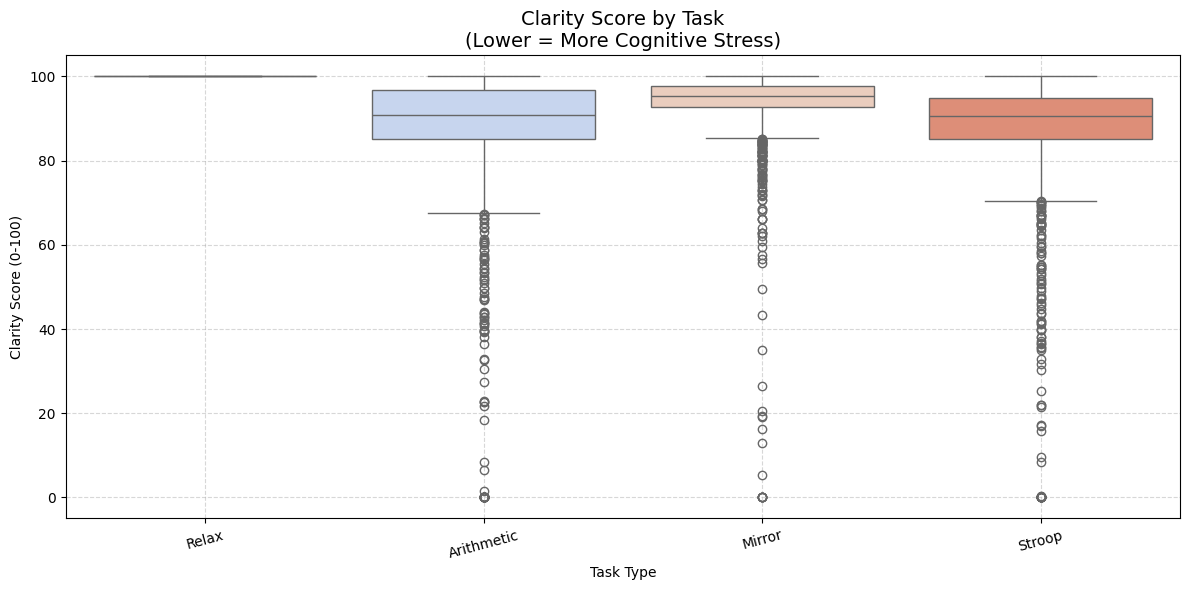

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample for plotting
sample_df = df.sample(n=5000, random_state=42)

plt.figure(figsize=(12, 6))
sns.boxplot(data=sample_df, x="task", y="clarity_score", palette="coolwarm")
plt.title("Clarity Score by Task\n(Lower = More Cognitive Stress)", fontsize=14)
plt.ylabel("Clarity Score (0-100)")
plt.xlabel("Task Type")
plt.xticks(rotation=15)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
